In [155]:

import matplotlib.pyplot as plt
import numpy as np
from src.train.utils import calculate_aunl

import csv
import json
import numpy as np


In [156]:
df_loss = pd.read_csv('logs/loss.csv')
df_metrics = pd.read_csv('logs/metrics.csv')
df_trials = pd.read_csv('logs/trial_info.csv')

In [157]:
# Increase CSV parser limit
csv.field_size_limit(10_000_000)

# Load and clean
clean_rows = []
expected_columns = 4
with open("logs/eval_data.csv", encoding="utf-8") as f:
    reader = csv.reader(f, quotechar='"', doublequote=True)
    for row in reader:
        if row[0] == "model_name":
            continue
        if len(row) == expected_columns:
            clean_rows.append(row)

# Build DataFrame
columns = ['model_name', 'component', 'y_true', 'y_pred']
df_data = pd.DataFrame(clean_rows, columns=columns)

# Safe JSON parse function
def safe_json_parse(s, name=""):
    try:
        return json.loads(s)
    except Exception as e:
        print(f"⚠️ Failed to parse {name}: {str(e)}\nSnippet: {s[:100]}...")
        return None

# Parse and convert to numpy array WITHOUT flattening (to keep shape)
def parse_to_numpy_array(s, name=""):
    parsed = safe_json_parse(s, name)
    if parsed is None:
        return None
    try:
        arr = np.array(parsed)
        # If the array has shape (n,1), reshape to (n,) or keep as is depending on your needs
        if arr.ndim == 2 and arr.shape[1] == 1:
            arr = arr.reshape(-1)  # flatten last dim but keep sample dimension
        return arr
    except Exception as e:
        print(f"⚠️ Conversion to numpy array failed for {name}: {e}")
        return None


In [164]:
def plot_top_selection(df, col, good=True, k=3):
    """
    Plot top 10 models with the smallest AUNL, annotated with AUNL values.
    
    Parameters:
    - df_aunl: DataFrame with columns ['model', 'aunl']
    """
    # Sort and select top 10
    topK = df.sort_values(col, ascending=good).head(k)

    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(topK["model"], topK[col])
    plt.xlabel("AUNL")
    plt.ylabel("Model")
    plt.title("Top 10 Models with Smallest AUNL")
    plt.gca().invert_yaxis()  # Smallest at the top

    # Annotate values
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height() / 2,
                 f"{width:.4f}", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()

    return topK

In [160]:
# Ensure loss columns are floats
df_loss["train_loss"] = df_loss["train_loss"].astype(float)
df_loss["val_loss"] = df_loss["val_loss"].astype(float)


df_metrics_test = df_metrics[df_metrics["type"] == "test"]

group_cols = ["model"]
# Apply and unpack two outputs into a DataFrame
model_aunl_scores = (
    df_loss
    .groupby("model")
    .apply(lambda group: pd.Series(
        calculate_aunl(group["train_loss"].values, group["val_loss"].values),
        index=["aunl", "val_aunl"]
    ))
    .reset_index()
)

df_merged = pd.merge(df_metrics_test, model_aunl_scores, how="left", on=group_cols)

C:\Users\janav\AppData\Local\Temp\ipykernel_21588\148126953.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series(


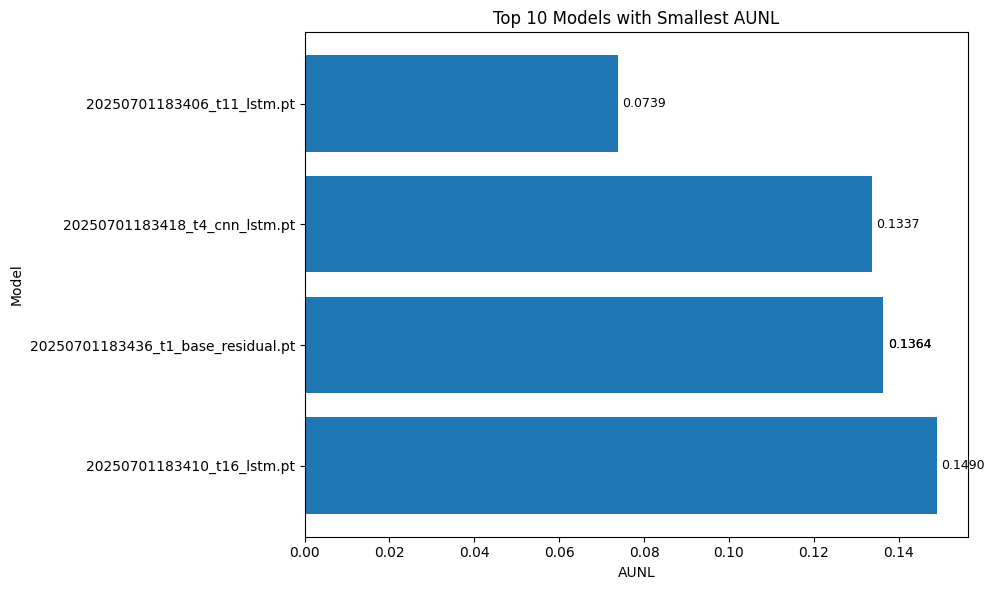

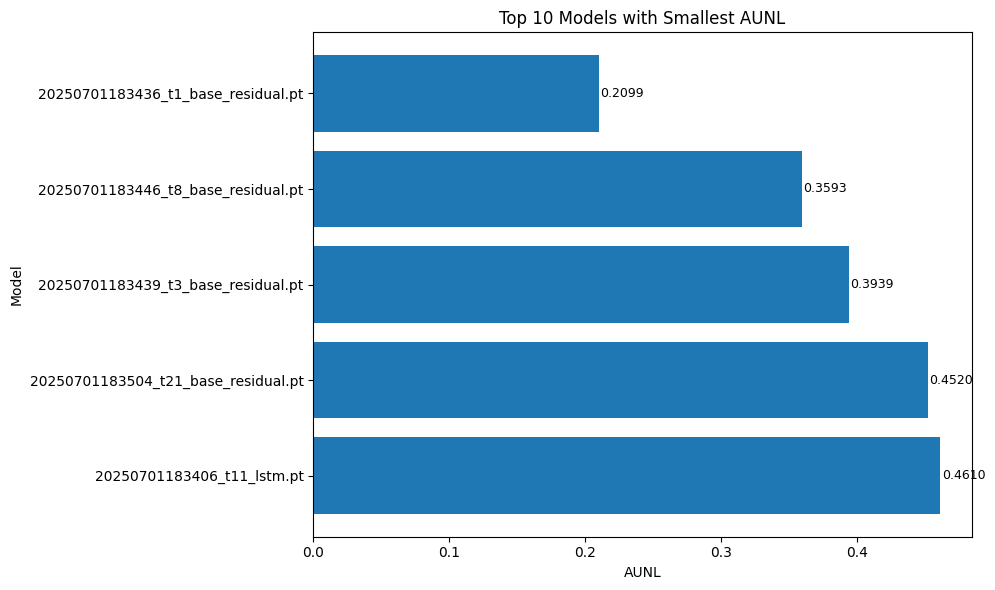

In [165]:
models1 = plot_top_selection(df_merged, 'val_aunl', k=5)
models2 = plot_top_selection(df_merged, 'MAE', k=5)

In [177]:
import matplotlib.pyplot as plt

def plot_loss_subplots(df_loss, model_name):
    df_model = df_loss[df_loss['model'] == model_name]
    components = df_model['component'].unique()
    
    # Special case: only 'main'
    if len(components) == 1 and components[0] == 'main':
        df_main = df_model[df_model['component'] == 'main'].copy()
        # Min-max normalization for main component
        tmin, tmax = df_main['train_loss'].min(), df_main['train_loss'].max()
        vmin, vmax = df_main['val_loss'].min(), df_main['val_loss'].max()
        df_main['train_loss_norm'] = (df_main['train_loss'] - tmin) / (tmax - tmin + 1e-8)
        df_main['val_loss_norm'] = (df_main['val_loss'] - vmin) / (vmax - vmin + 1e-8)

        plt.figure(figsize=(9, 4))
        plt.plot(df_main['epoch'], df_main['train_loss_norm'], label='Train Loss (norm)')
        plt.plot(df_main['epoch'], df_main['val_loss_norm'], label='Val Loss (norm)', linestyle='--')
        plt.title(f"Model: {model_name} (main)")
        plt.xlabel('Epoch')
        plt.ylabel('Normalized Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        return
    
    # Otherwise, plot each component as a subplot
    n_plots = len(components)
    fig, axs = plt.subplots(n_plots, 1, figsize=(9, 4 * n_plots), sharex=True)
    if n_plots == 1:
        axs = [axs]  # Make it iterable

    for i, comp in enumerate(components):
        df_comp = df_model[df_model['component'] == comp].copy()
        if df_comp.empty:
            continue
        # Min-max normalization for each component
        tmin, tmax = df_comp['train_loss'].min(), df_comp['train_loss'].max()
        vmin, vmax = df_comp['val_loss'].min(), df_comp['val_loss'].max()
        df_comp['train_loss_norm'] = (df_comp['train_loss'] - tmin) / (tmax - tmin + 1e-8)
        df_comp['val_loss_norm'] = (df_comp['val_loss'] - vmin) / (vmax - vmin + 1e-8)
        
        axs[i].plot(df_comp['epoch'], df_comp['train_loss_norm'], label=f'{comp} Train Loss (norm)')
        axs[i].plot(df_comp['epoch'], df_comp['val_loss_norm'], label=f'{comp} Val Loss (norm)', linestyle='--')
        axs[i].set_title(f"Model: {model_name} ({comp})")
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Normalized Loss')
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()


In [182]:
def plot_true_pred_from_df(df_data, model_name):
    # Only look at this model
    df_model = df_data[df_data['model_name'] == model_name]
    components = df_model['component'].unique()
    
    # Prefer 'main', otherwise fallback to 'residual'
    plot_comp = 'main' if 'main' in components else 'residual' if 'residual' in components else None
    if plot_comp is None:
        print(f"No 'main' or 'residual' component for model {model_name}")
        return
    
    df_comp = df_model[df_model['component'] == plot_comp]
    if df_comp.empty:
        print(f"No data for component '{plot_comp}' in model {model_name}")
        return
    
    # Should be only one row, but take the first just in case
    y_true = parse_to_numpy_array(df_comp.iloc[0]['y_true'], f"{model_name} y_true")
    y_pred = parse_to_numpy_array(df_comp.iloc[0]['y_pred'], f"{model_name} y_pred")

    if y_true is None or y_pred is None:
        print(f"Could not parse arrays for {model_name} ({plot_comp})")
        return

    plt.figure(figsize=(30, 7))
    plt.plot(y_true, color='blue', linewidth=0.5, label='True Values (t+1)')
    plt.plot(y_pred, color='red', linewidth=0.5, label='Predicted Values (t+1)')
    plt.title(f"{model_name} ({plot_comp}) - Forecast Step t+1: Predicted vs True")
    plt.xlabel("Time Step")
    plt.ylabel("Rescaled Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

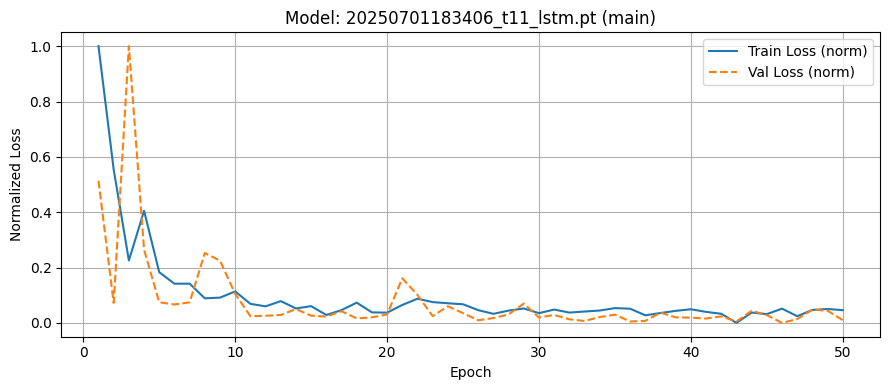

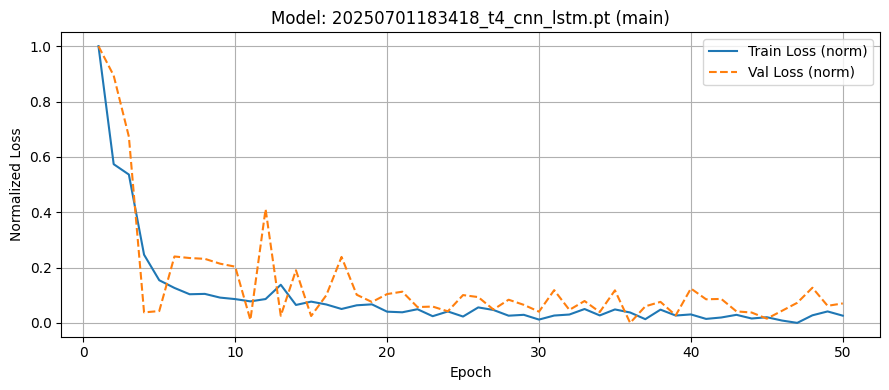

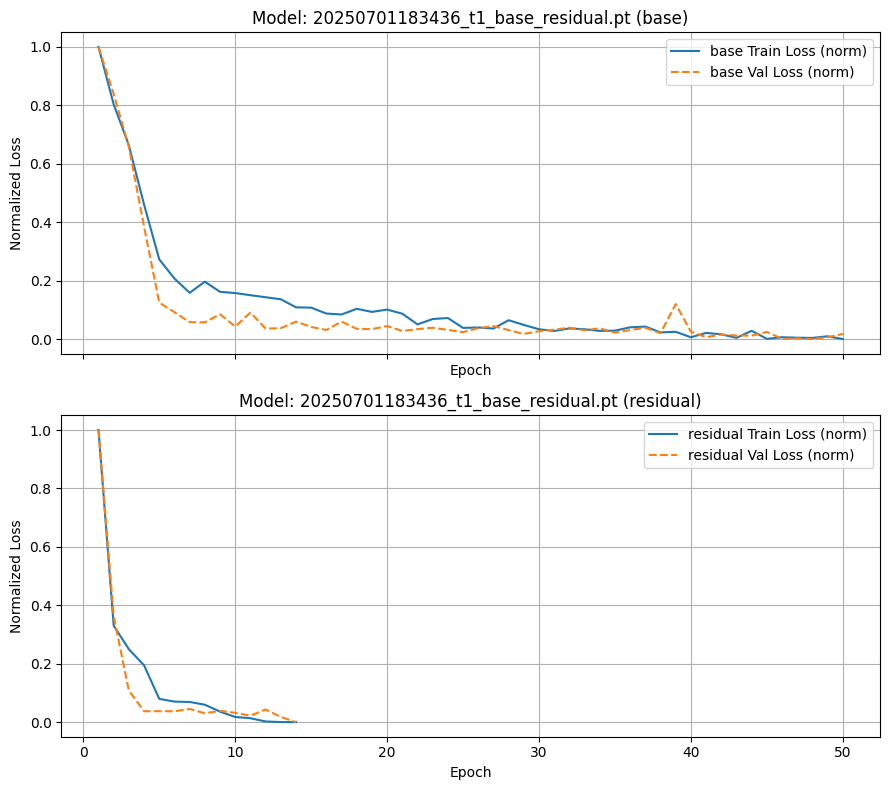

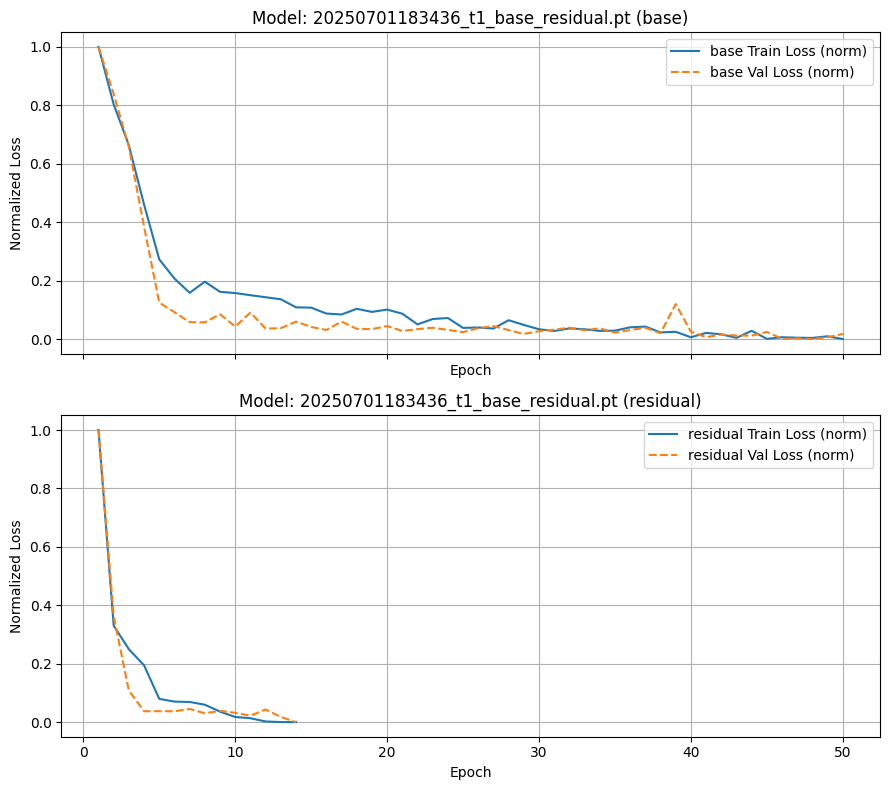

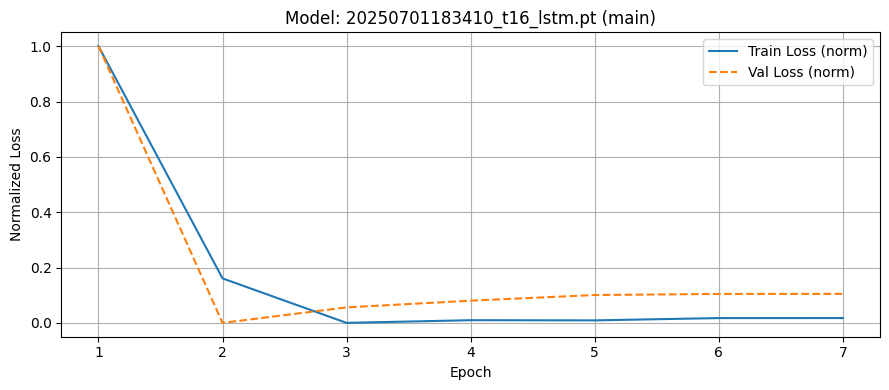

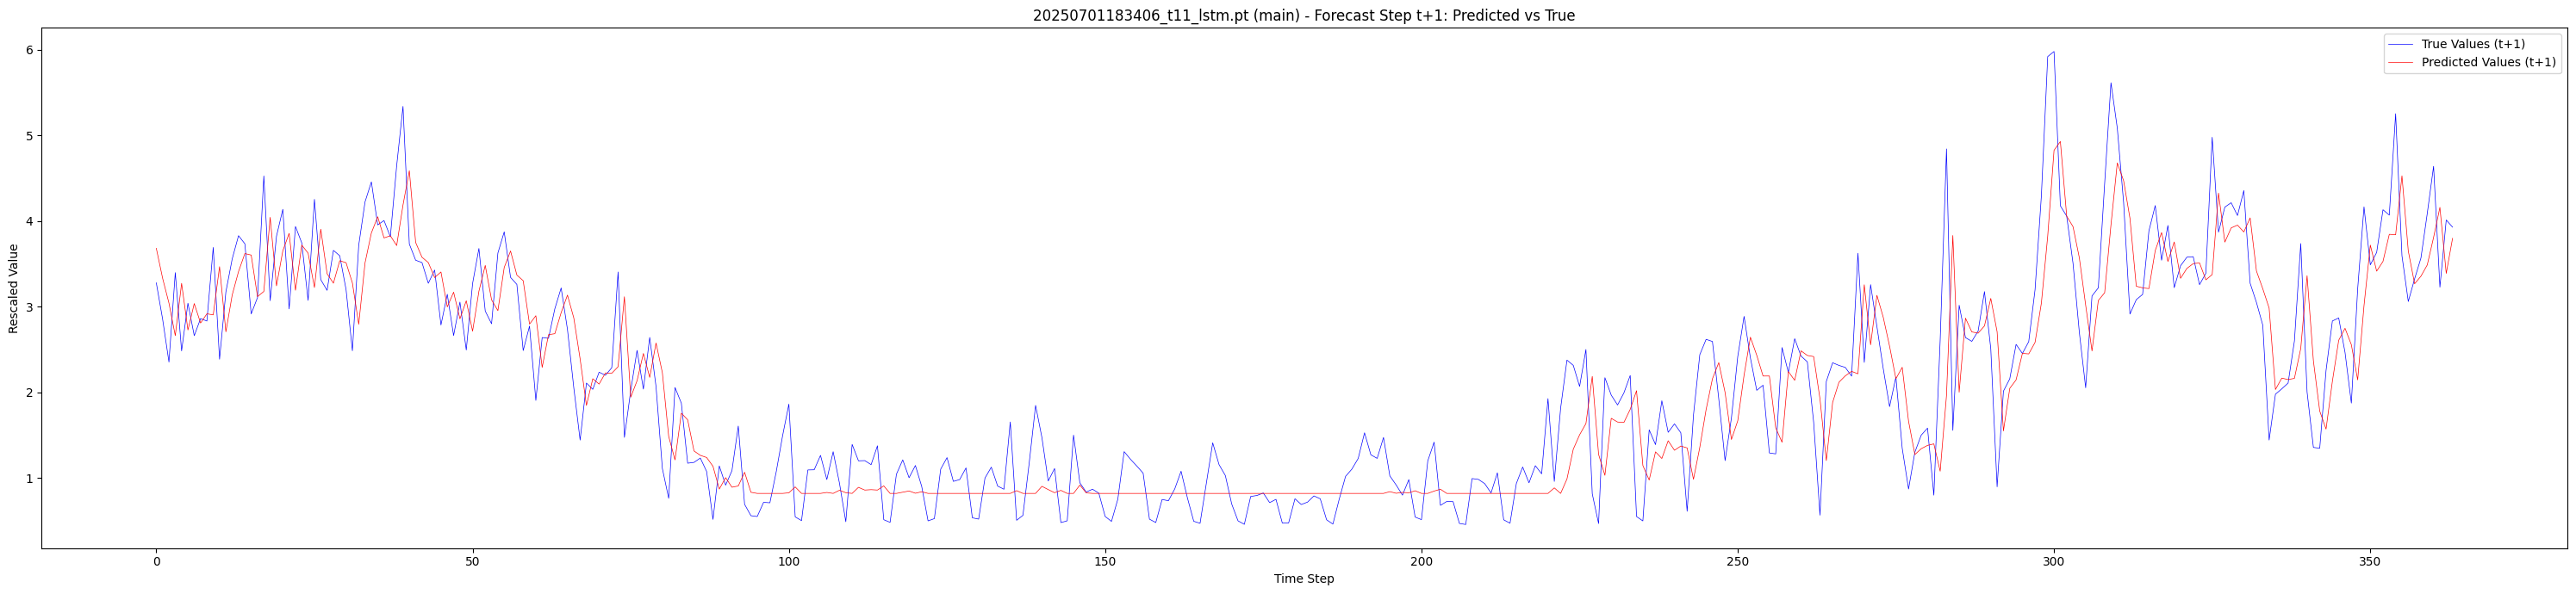

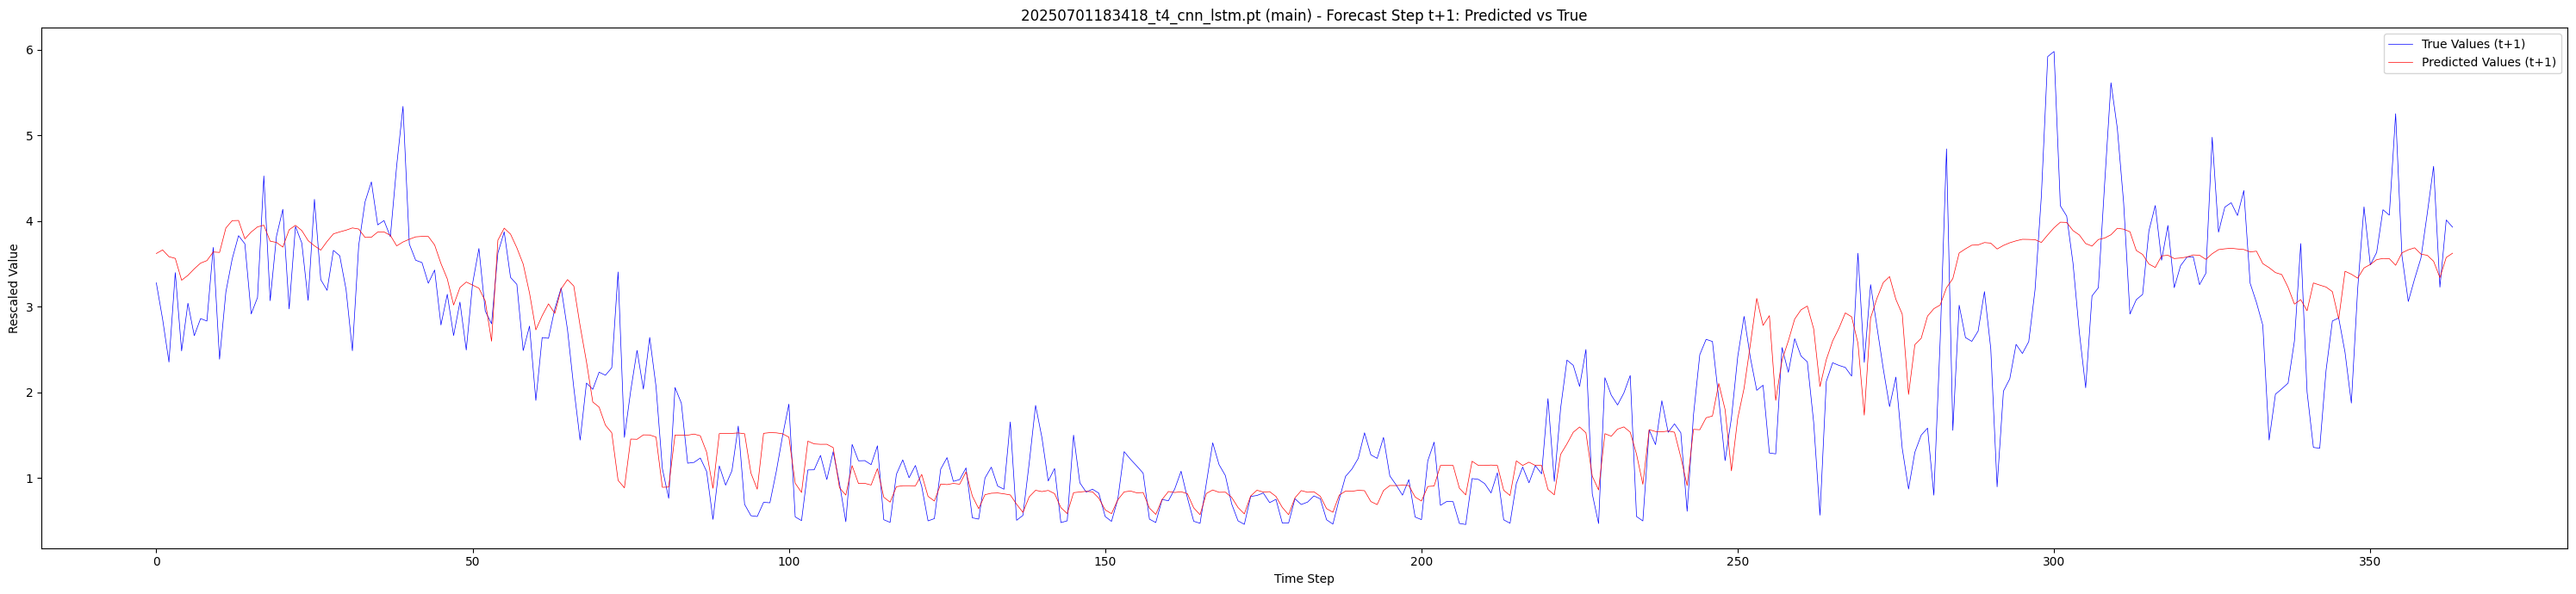

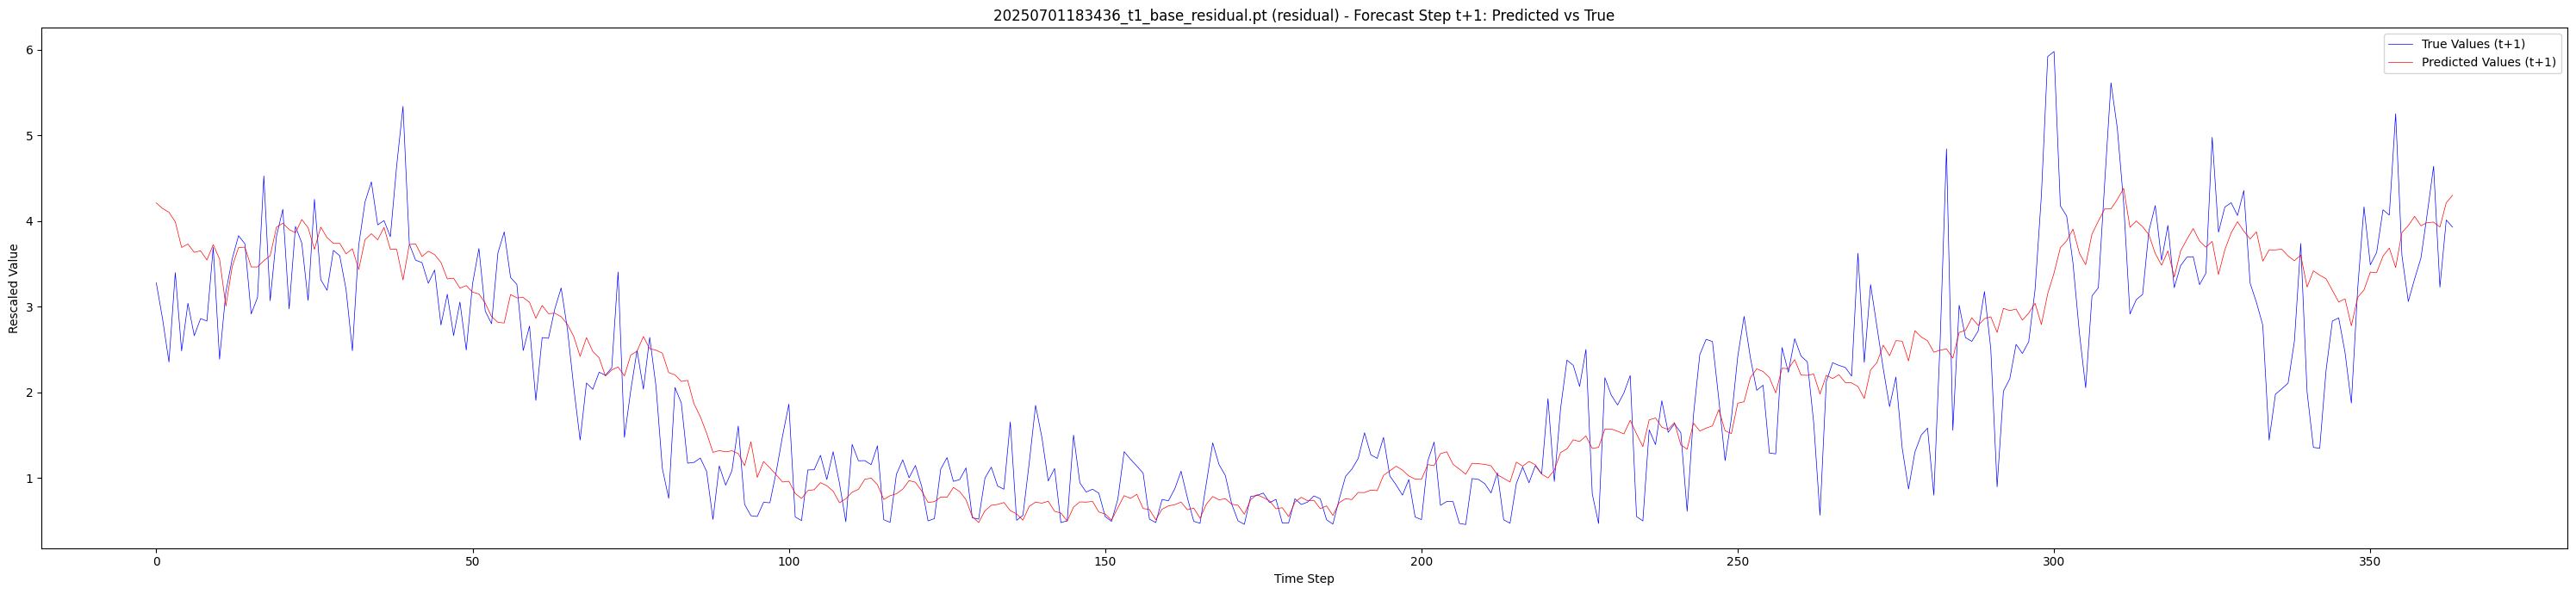

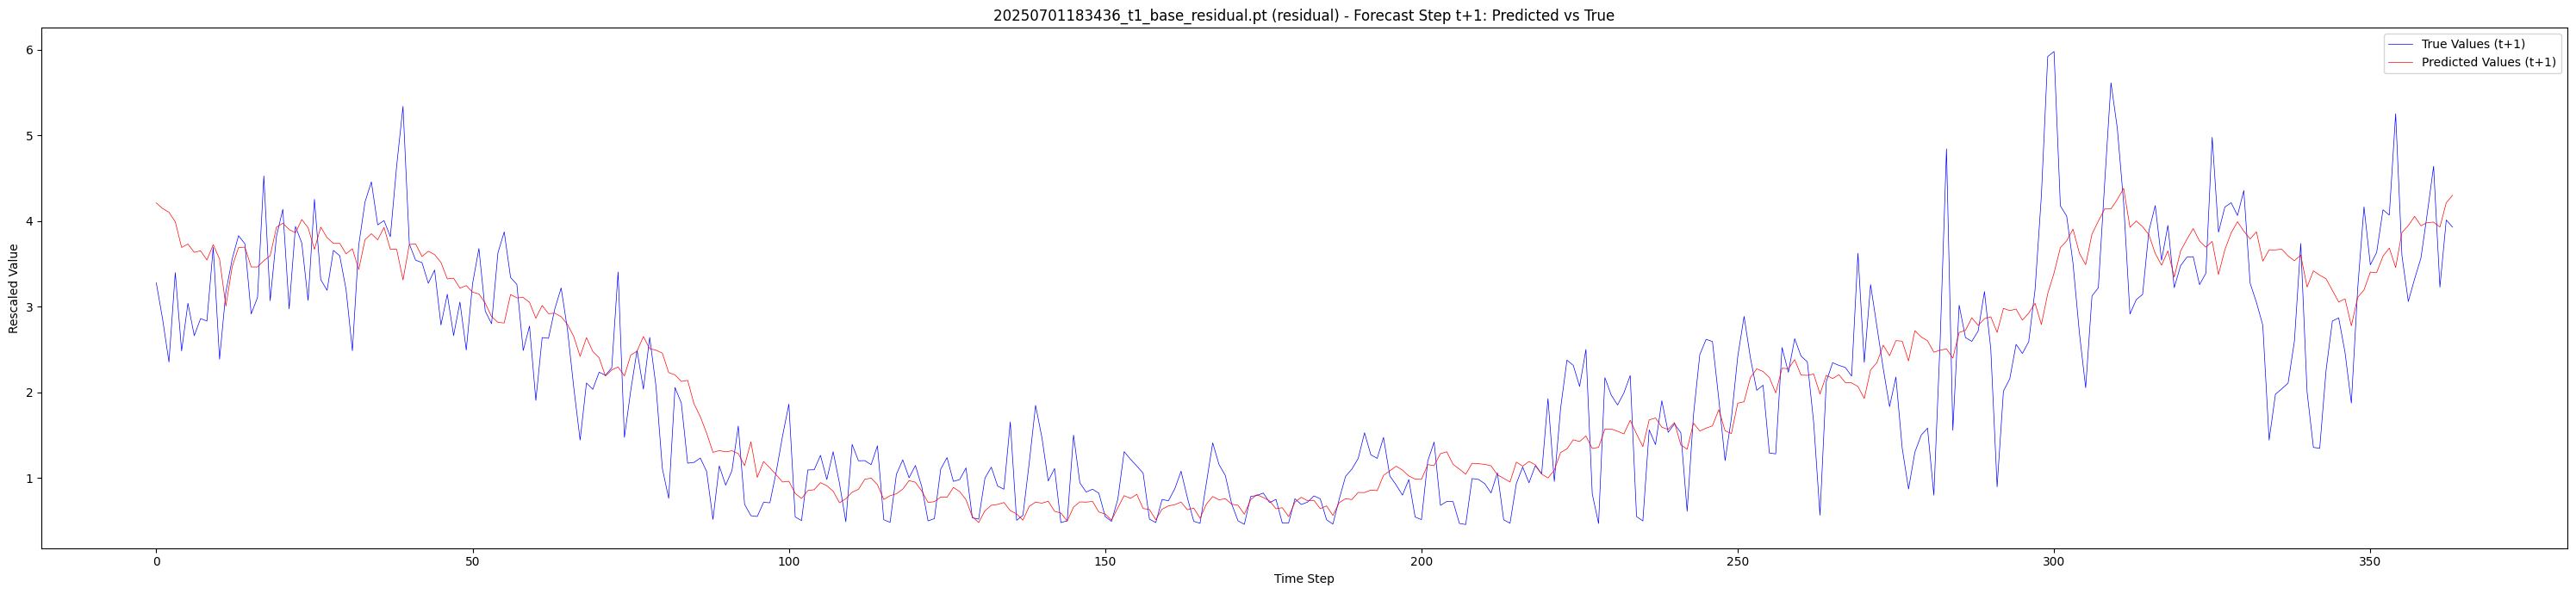

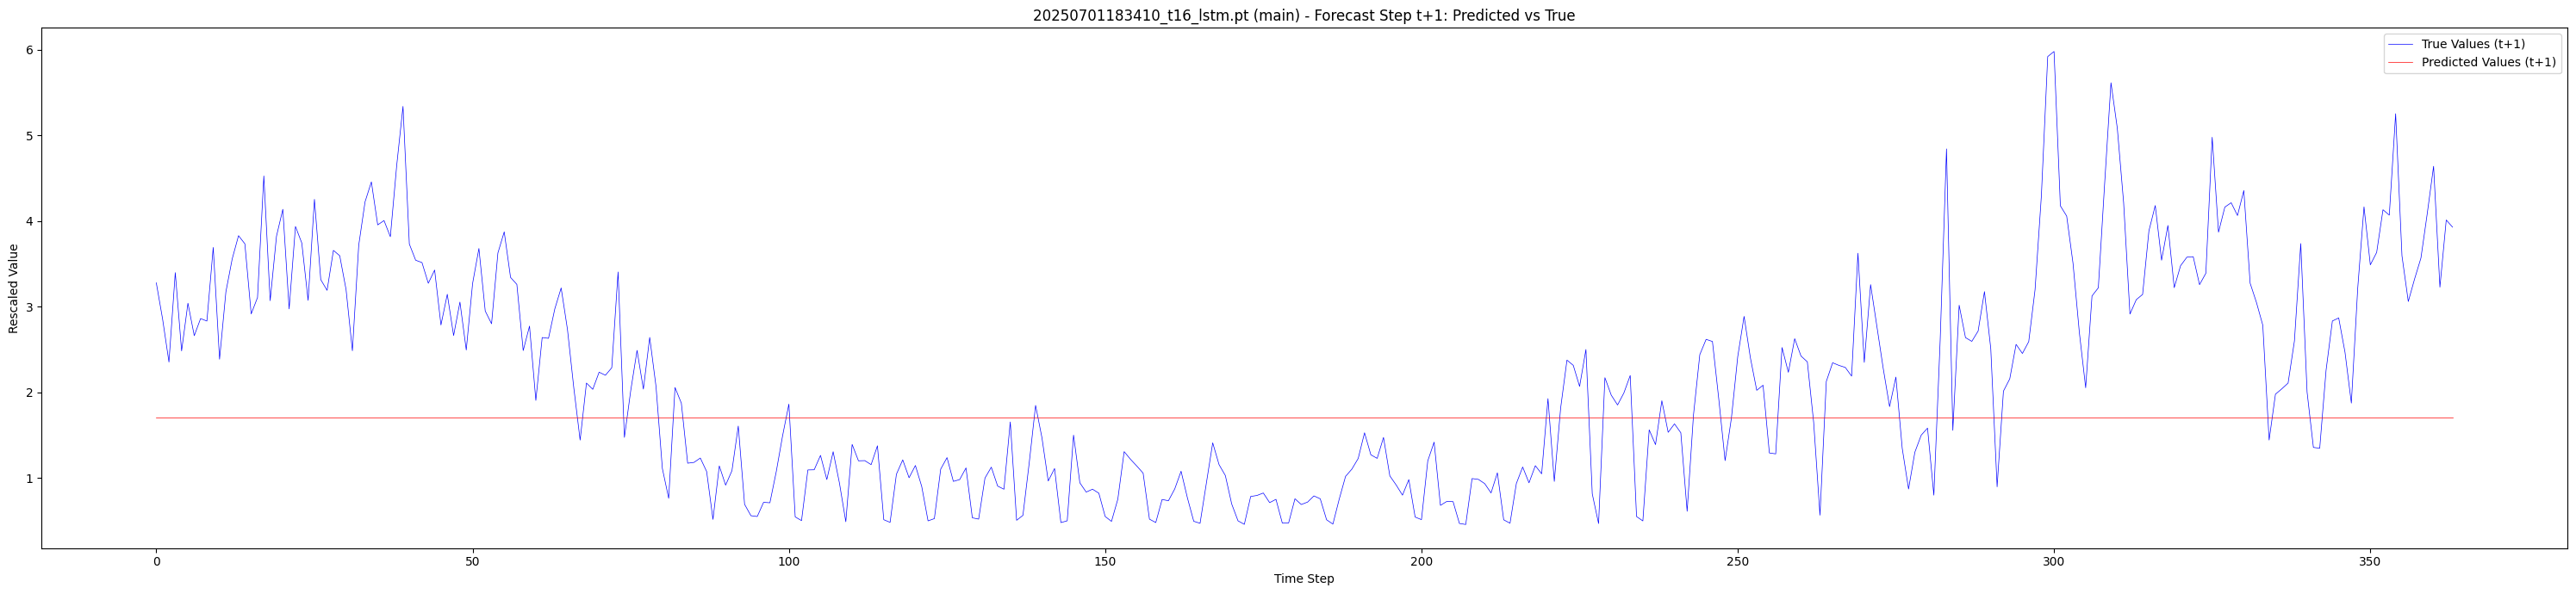

In [184]:
for model_name in models1['model'].values:
    plot_loss_subplots(df_loss, model_name)

for model_name in models1['model'].values:
    plot_true_pred_from_df(df_data, model_name)


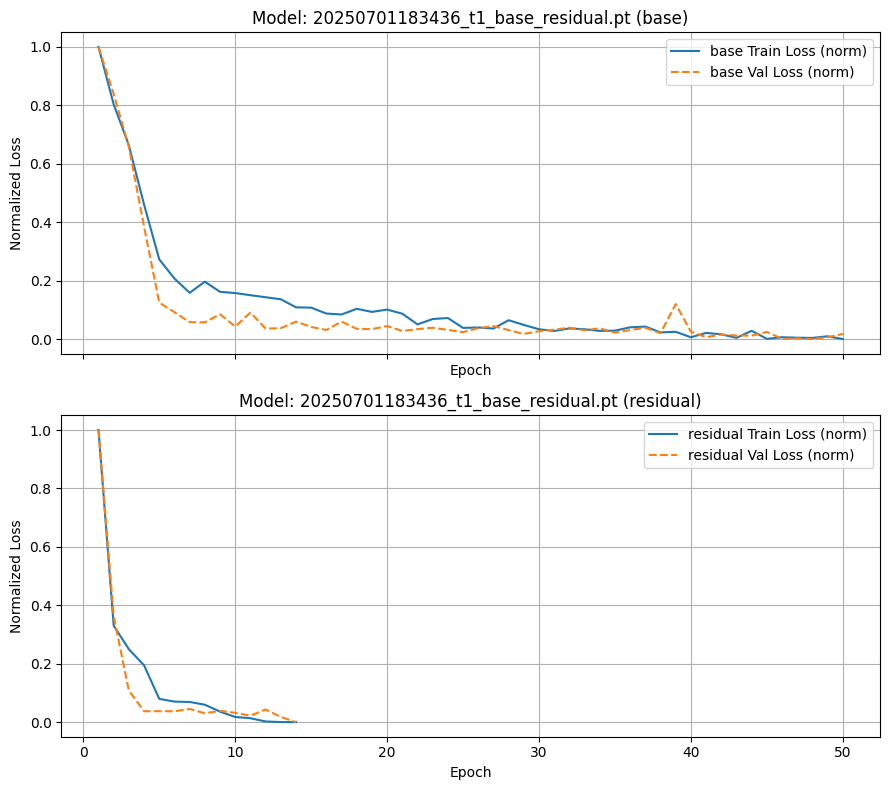

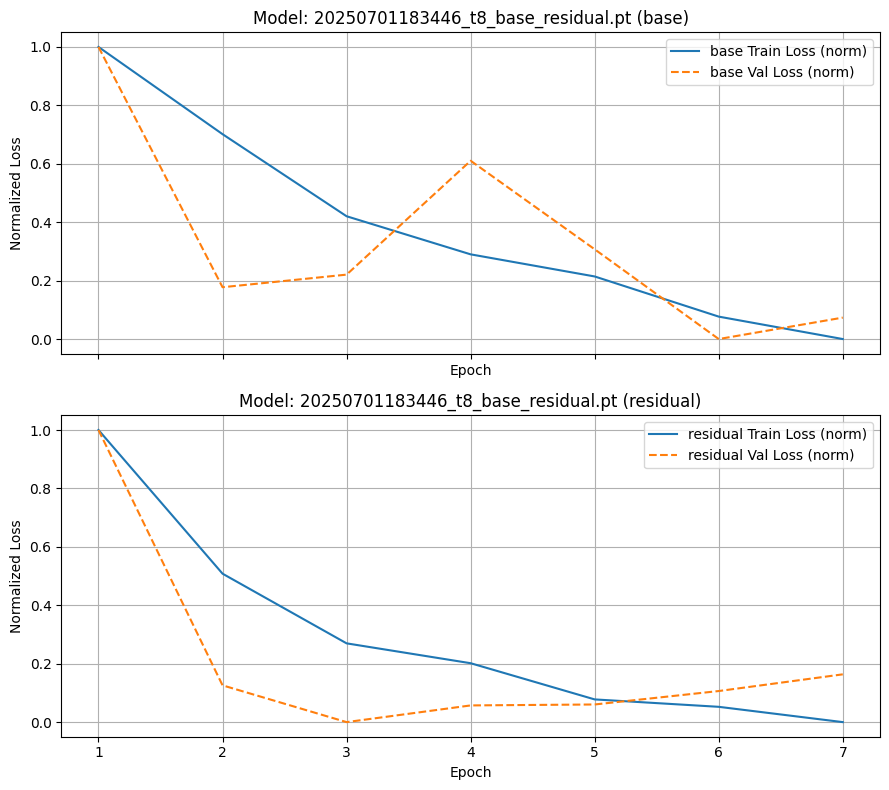

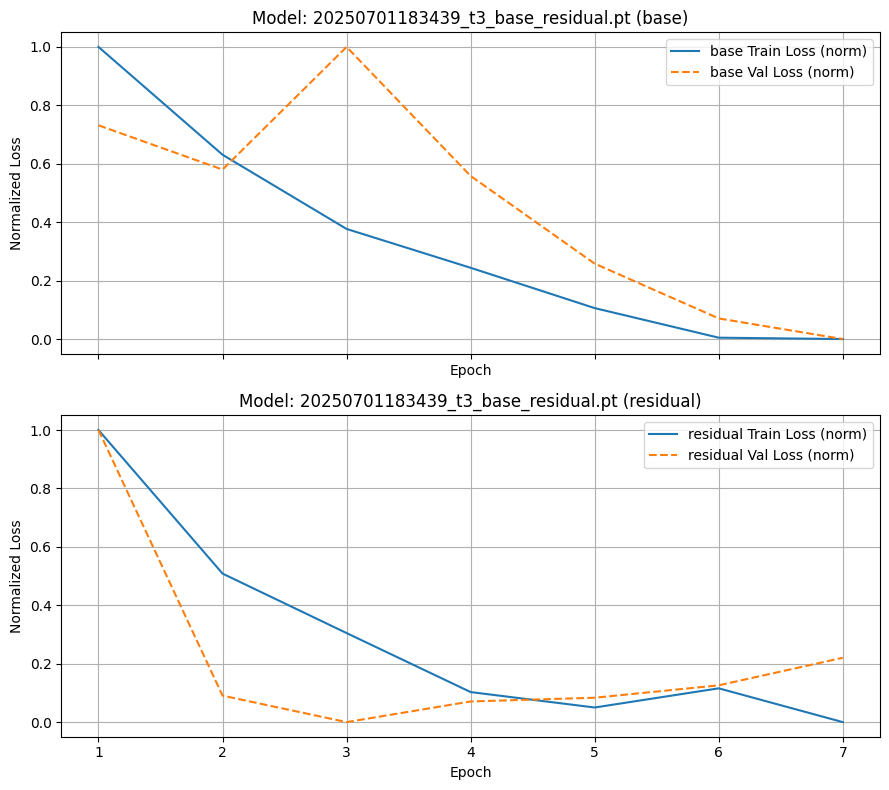

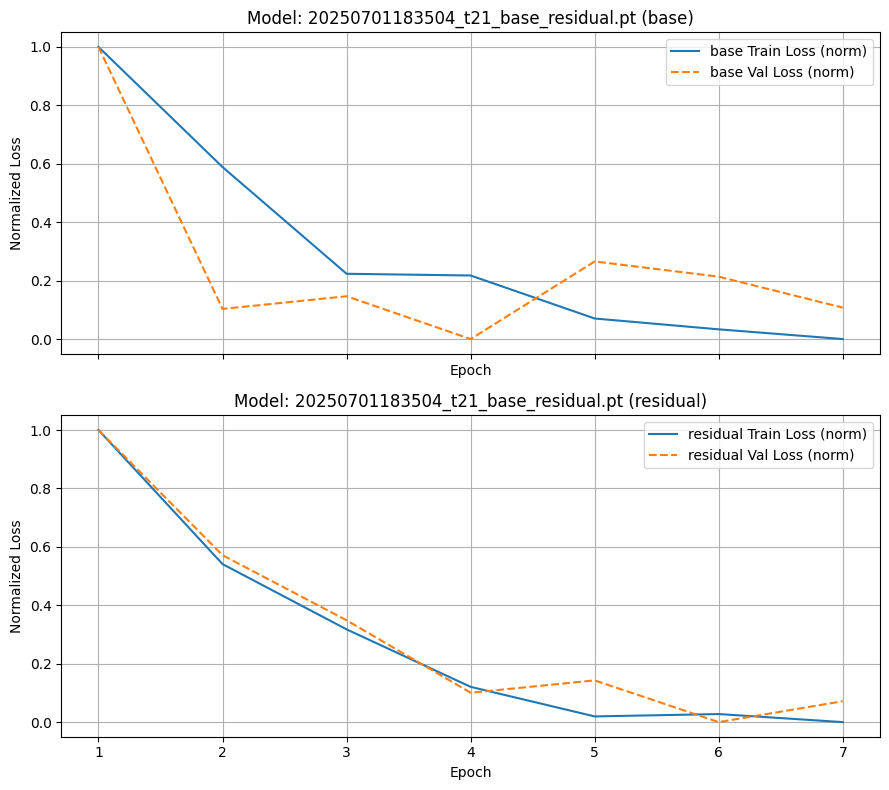

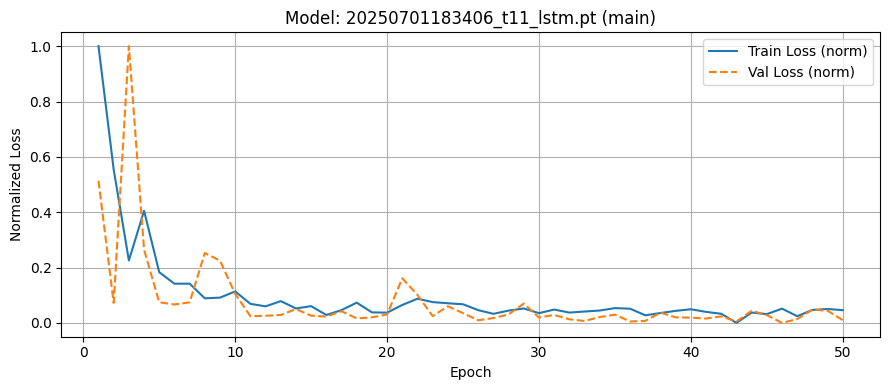

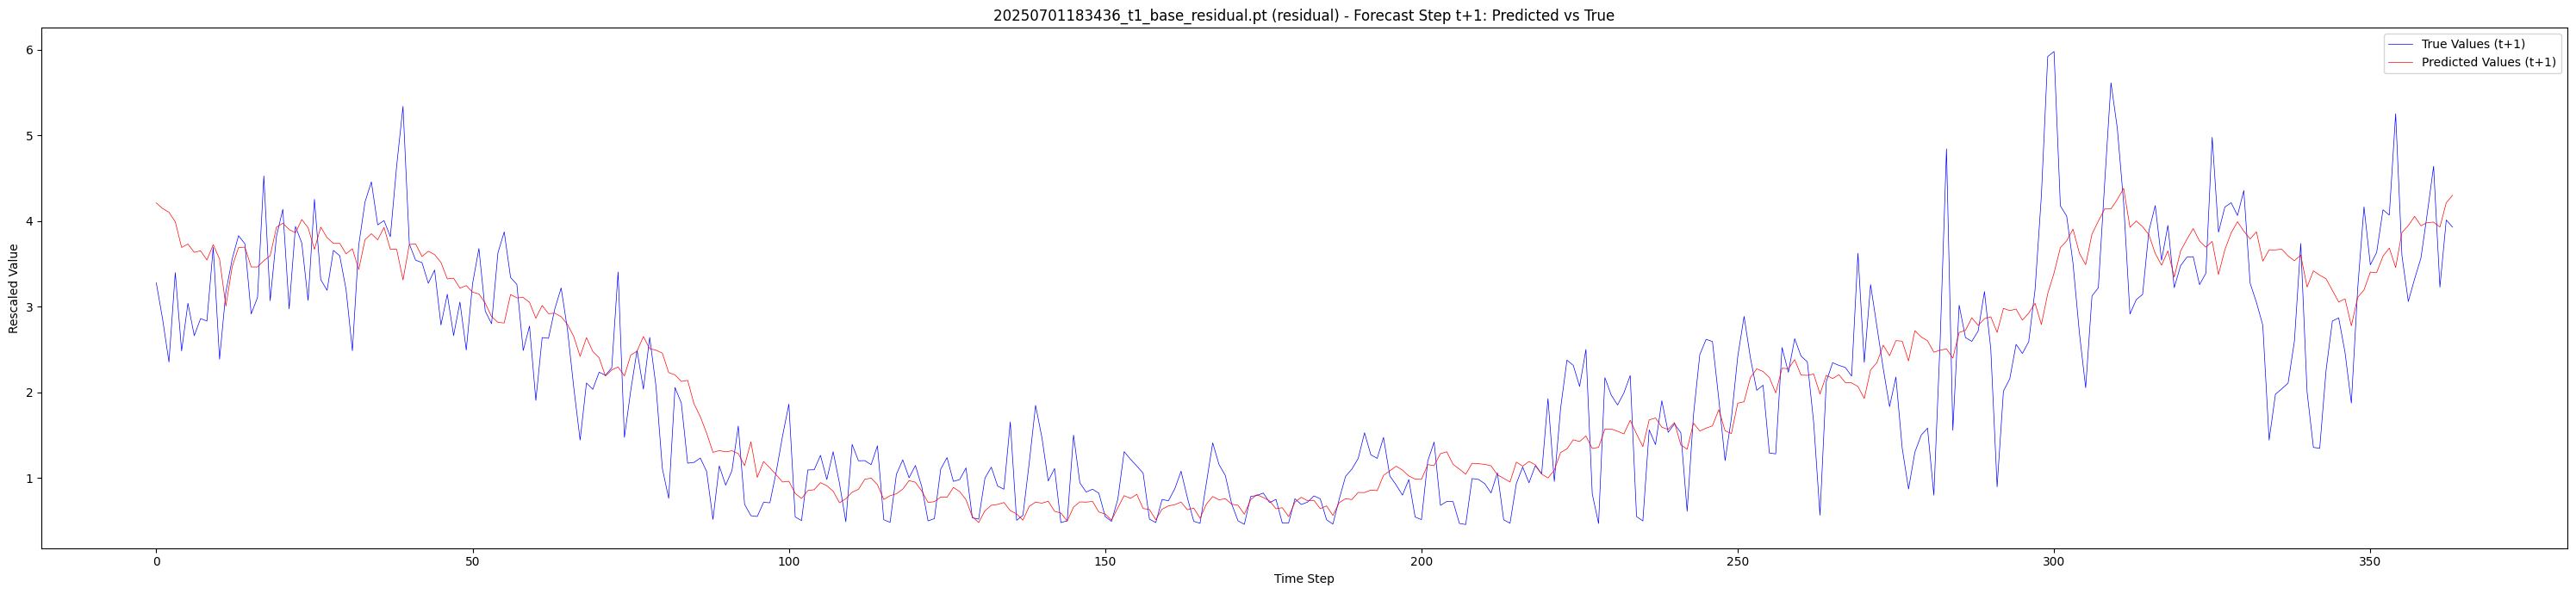

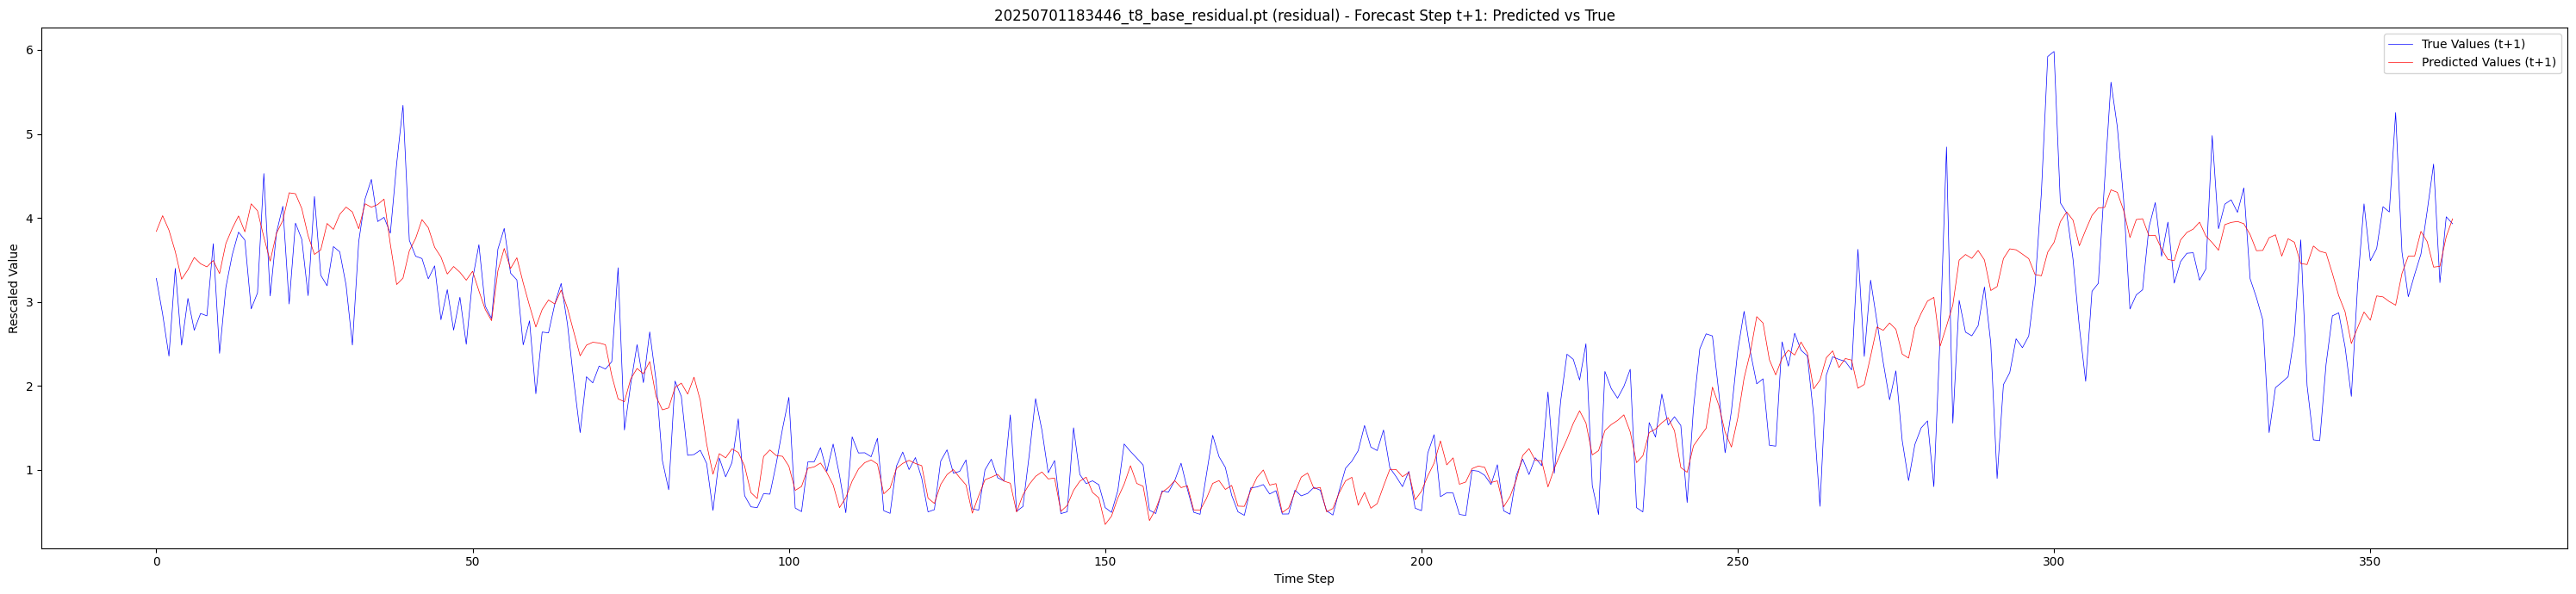

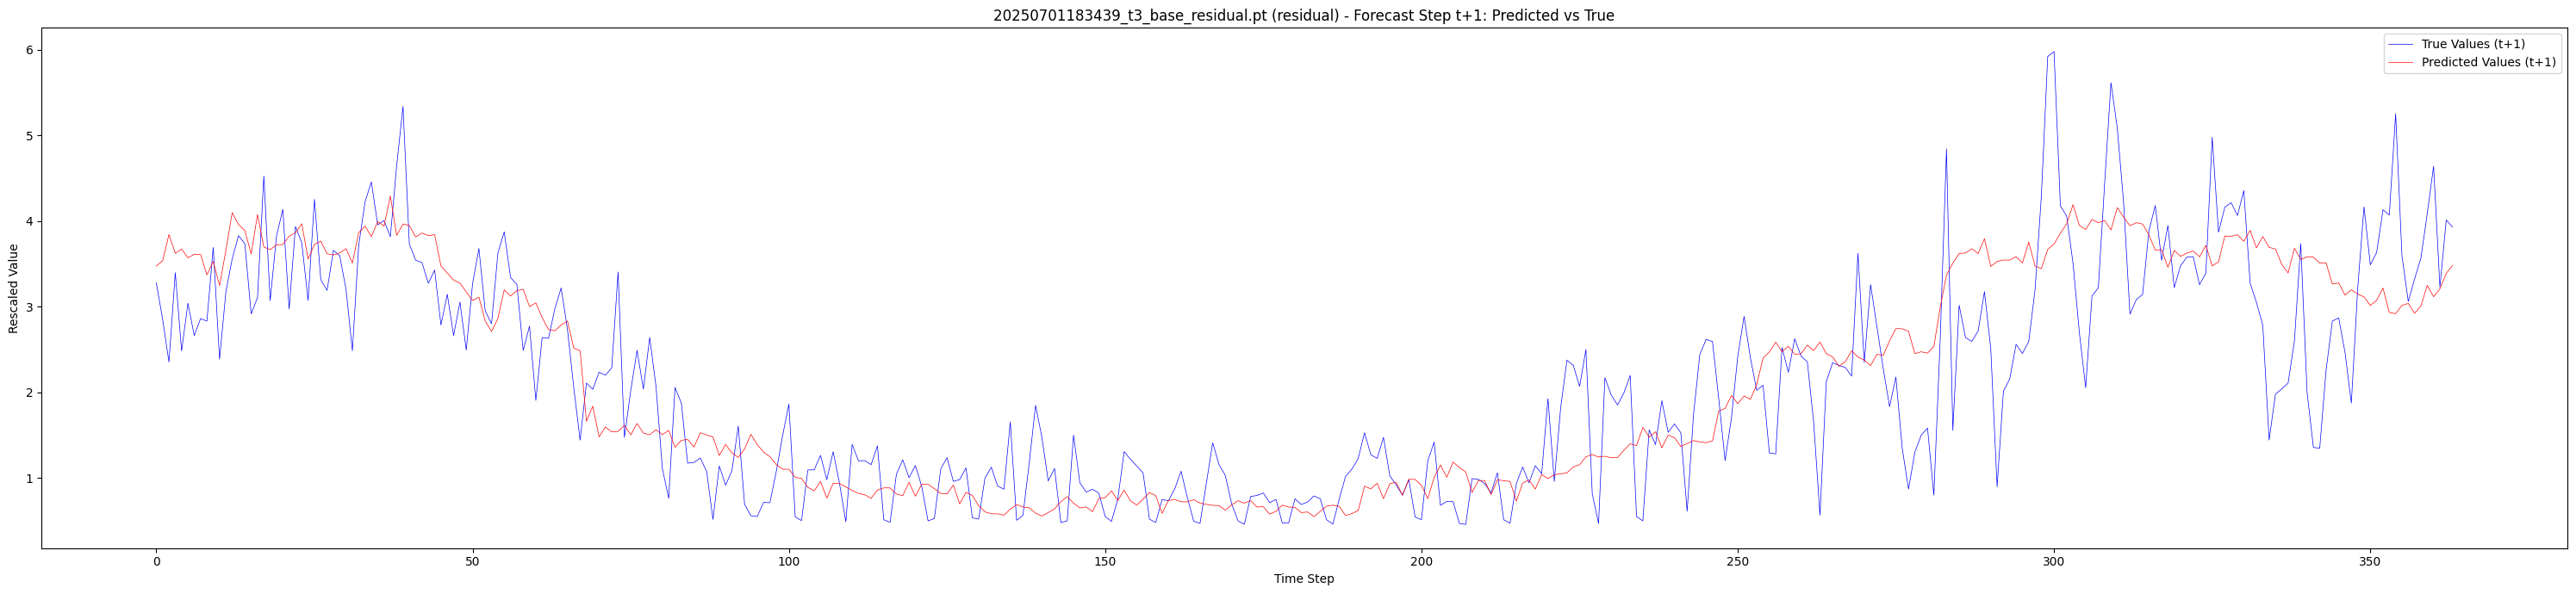

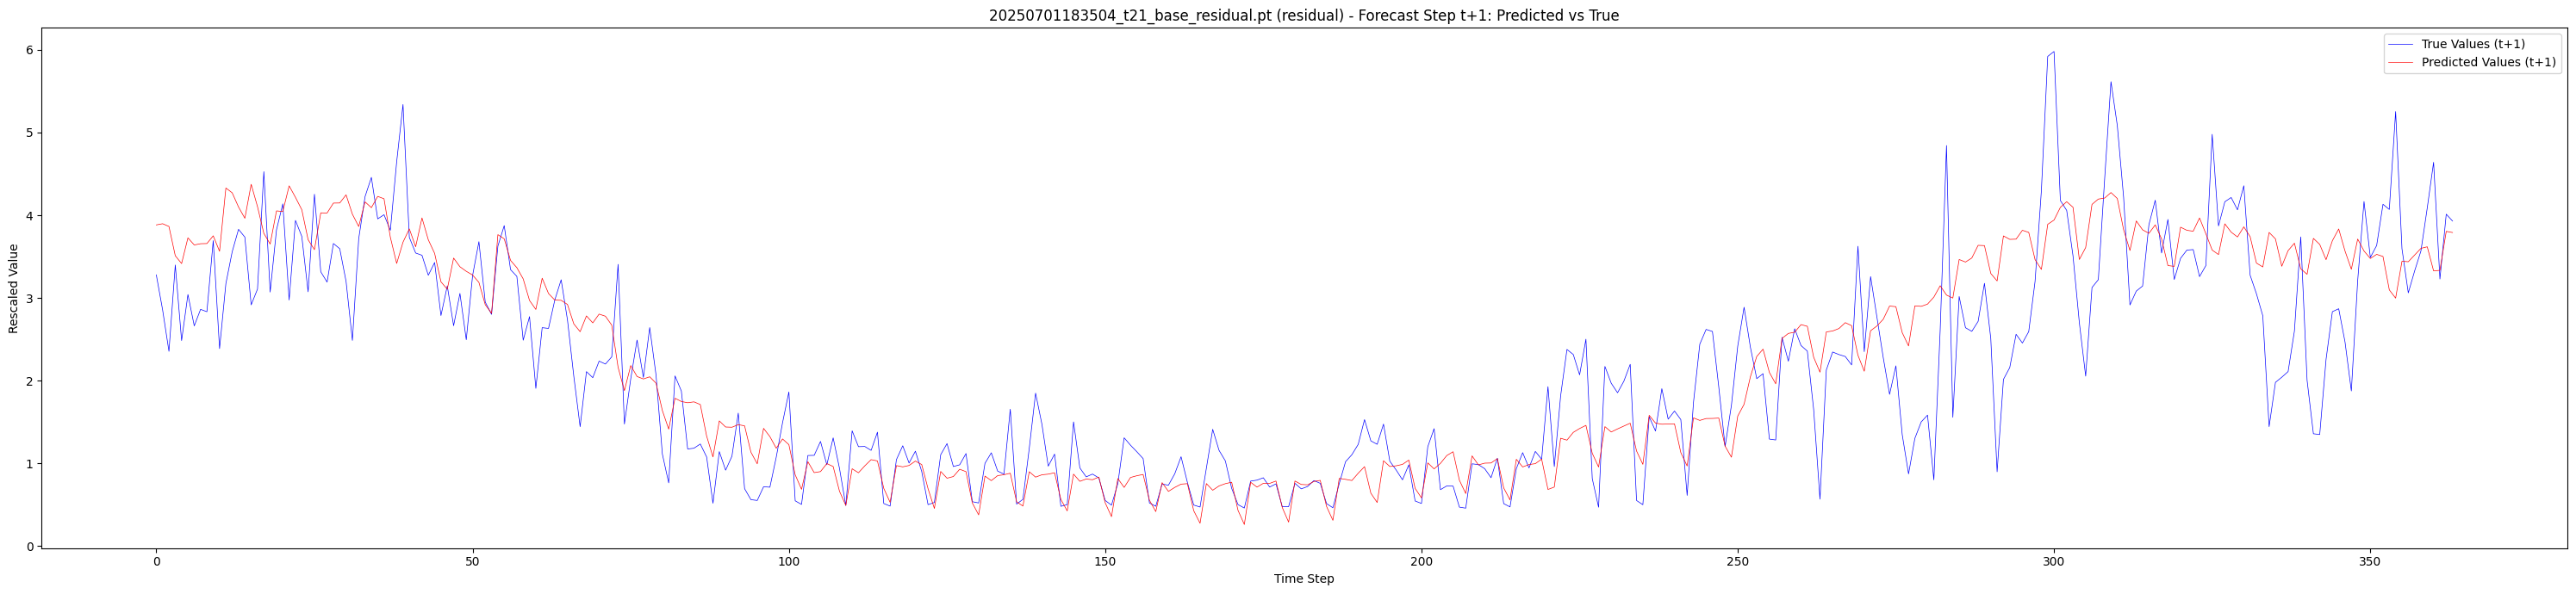

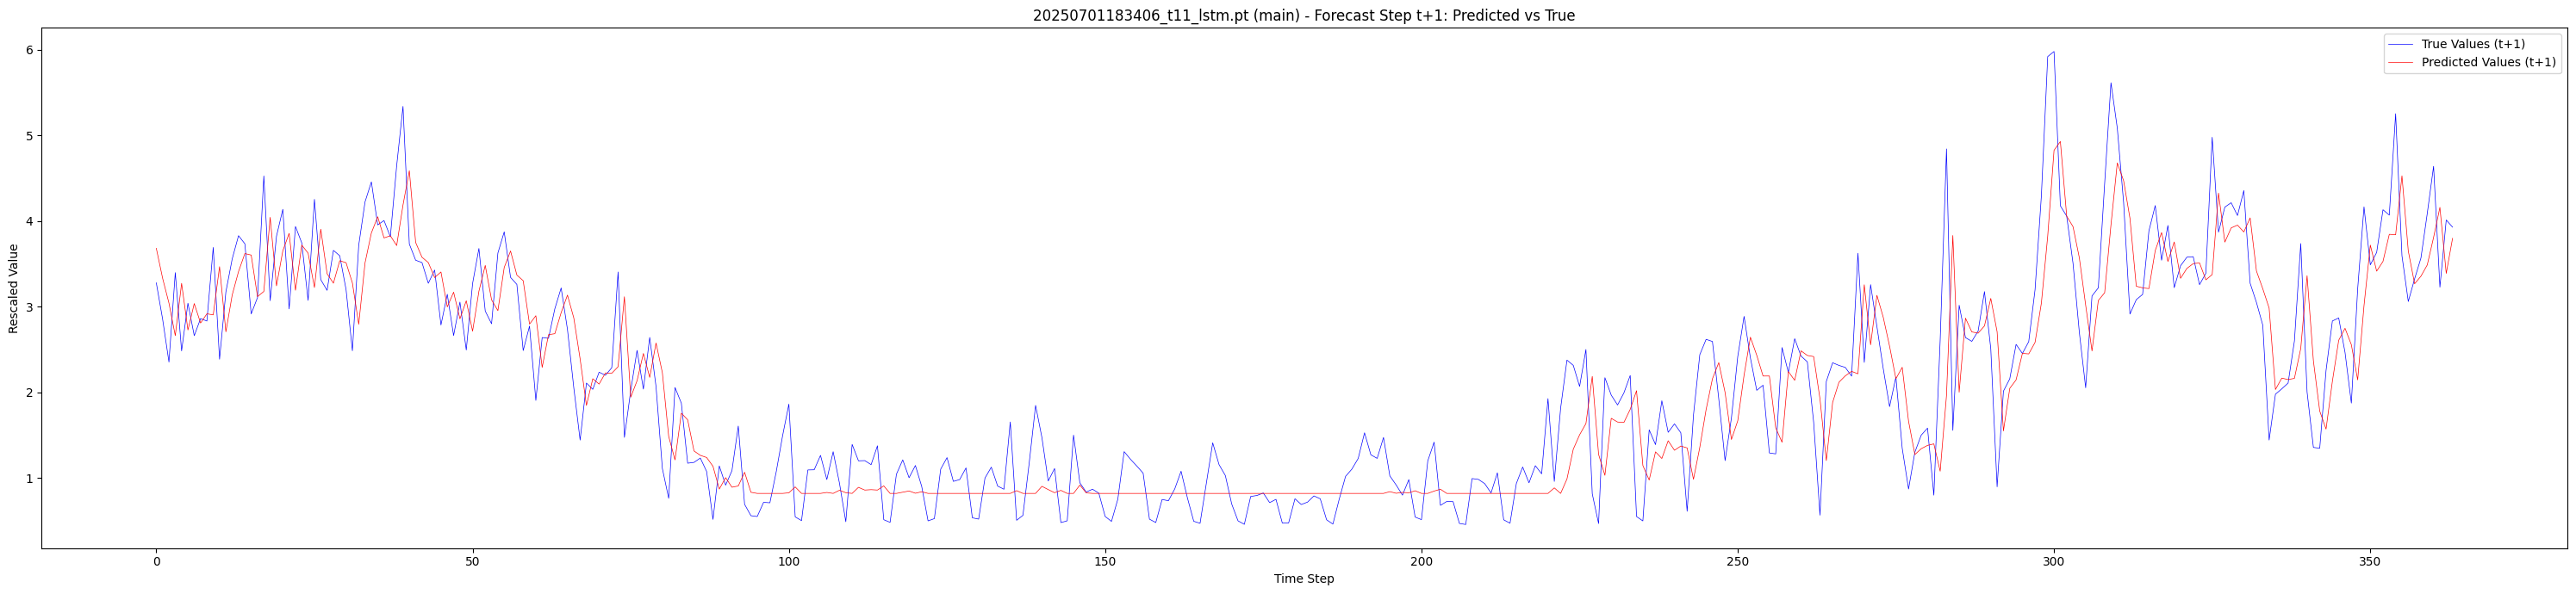

In [185]:
for model_name in models2['model'].values:
    plot_loss_subplots(df_loss, model_name)

for model_name in models2['model'].values:
    plot_true_pred_from_df(df_data, model_name)
